# Import

In [1]:
import os, joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica'

import seaborn as sns

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate

In [2]:
current = os.getcwd()
os.chdir('../modelEval')

In [3]:
from scripts.evalModel import countDrugsK

In [4]:
os.chdir(current)

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Define funcs

In [6]:
def loadEncoder(path, which='rna'):
    try:
        snn = load_model(path)
        encoder = snn.get_layer('model')
        encoder._name = f'{which}Encoder'
        return encoder
    except AttributeError:
        return None
    
def getModel(rnaPath=None, drugPath=None, rnaDim=463, drugDim=256):
        # Define encoded drug input
        drugInput = Input(drugDim)
        rnaInput = Input(rnaDim)
                                             
        if drugPath == None:
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugInput, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugInput, rnaEmbed])
        else:
            drugEmbed = loadEncoder(drugPath, which='drug')(drugInput)
            if rnaPath == None:         
                pairEmbed = Concatenate()([drugEmbed, rnaInput])
            else: 
                rnaEmbed = loadEncoder(rnaPath)(rnaInput)
                pairEmbed = Concatenate()([drugEmbed, rnaEmbed])

        return Model(inputs=[drugInput, rnaInput], outputs=pairEmbed)

## Define paths

## Cell line encoder

In [35]:
rnaPath = '../../models/cellEncoders/'

rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = os.path.join(rnaPath, rnaModel)


## Drug encoder

In [8]:
drugPath = '../../models/drugEncoders/'
drugModel = 'DrugFewShot_Layers1_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
drugPath = os.path.join(drugPath, drugModel)

# Load Data

## RNA

In [9]:
testRNA = pd.read_csv('../../data/processed/RNA_test_cancergenes.csv', index_col=0)
newRNA = pd.read_csv('../../data/processed/RNA_newcancer_cancergenes.csv', index_col=0)

## Drugs

In [10]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## CDR

In [11]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
cdrFilt = cdr.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'ic50', 'auc', 'effectiveCont', 'effective']]
cdrFilt.rename(columns={'DepMap_ID': 'cell_line', 'name': 'drug', 'effective': 'true'}, inplace=True)
cdrFilt.head()

,cell_line,cancer_type,drug,ic50,auc,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,3.801377,0


## Data

In [12]:
testCDR = cdrFilt[cdrFilt.cell_line.isin(testRNA.index)]

testData = [drugs.loc[list(testCDR.drug.values), :].to_numpy(), 
            testRNA.loc[list(testCDR.cell_line.values), :].to_numpy()]

newCDR = cdrFilt[cdrFilt.cell_line.isin(newRNA.index)]

newData = [drugs.loc[list(newCDR.drug.values), :].to_numpy(), 
            newRNA.loc[list(newCDR.cell_line.values), :].to_numpy()]

# Process data

In [13]:
models = {}

## RF

In [14]:
models['rf'] = joblib.load('../../models/SiamCDR/RF/EmbedDrug-EmbedCell-RF-CVfold1.joblib')

## LR

In [15]:
models['lr'] = joblib.load(f'../../models/SiamCDR/LR/RawDrug-EmbedCell-LR-CVfold3.joblib')

## DNN

In [16]:
dnnBasePath = '../../models/SiamCDR/DNN/'
dnnName = f'RawDrug-EmbedCell-DNN_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_CVfold1'
dnnModelPath = os.path.join(dnnBasePath, dnnName)
models['dnn'] = load_model(dnnModelPath)

## DeepDSC

In [17]:
models['dsc'] = load_model(f'../../models/DeepDSC/DeepDSC_fold2')

# Get test preds

In [47]:
predDFs = {}
for name, model in models.items():
    if name in ['rf', 'lr']:
        cp = rnaPath
        if name == 'rf':
            dp = drugPath
        else:
            dp = None
            
        encoder = getModel(cp, dp)
        preds = [p[1] for p in model.predict_proba(encoder(testData))]    
        
    else:
        td = testData
        if name == 'dsc':
            td = [testData[1], testData[0]]
        preds = model.predict(td).reshape(-1)
        
    df = testCDR.copy()
    df['pred'] = preds
    predDFs[name] = df

In [37]:
for m, preds in predDFs.items():
    if m != 'dsc':
        topDrugs = preds[preds.pred >= 0.5].drug.unique()
        meanVar = preds[preds.drug.isin(topDrugs)].groupby(by='cell_line').pred.var().mean()
        print(f"{m}'s average variance in score by drug: {meanVar}")
    else:
        print(f"{m} -- Min score: {preds.pred.min()}; Max score: {preds.pred.max()}")

rf's average variance in score by drug: 0.0748599571847387
lr's average variance in score by drug: 0.0364428171789395
dnn's average variance in score by drug: 0.027467843145132065
dsc -- Min score: 0.06857115030288696; Max score: 0.258916437625885


In [38]:
predDFs['dsc'].groupby(by='cell_line').pred.var().mean()

0.00043393899

In [39]:
drugList = [d for d in predDFs['dsc'].drug.unique() if predDFs['dsc'].drug.value_counts()[d] > 1]

In [40]:
predDFs['dsc'][predDFs['dsc'].drug.isin(drugList)].groupby(by='drug').pred.var().mean()

0.0001643892

# Get drug counts in top 5

In [41]:
counts = {}
for model, df in predDFs.items():
    df.loc[:, ['cell_line', 'cancer_type', 'drug', 'effectiveCont', 'true', 'pred']]
    cDF = countDrugsK(df, k=5, getPcnt=True)[0]
    cDF = cDF[cDF.total > 2]
    counts[model] = cDF

No true effective drugs identified in top 5 for ACH-000086 (top drug: echinomycin)
No true effective drugs identified in top 5 for ACH-000164 (top drug: epothilone-b)
No true effective drugs identified in top 5 for ACH-000823 (top drug: echinomycin)


## Find overlapping drugs

In [42]:
first = True
for model, df in counts.items():
    if first:
        overlap = set(df.index)
        first = False
    else:
        overlap = overlap.intersection(set(df.index))

In [43]:
overlap

{'10-hydroxycamptothecin',
 'cabazitaxel',
 'dolastatin-10',
 'echinomycin',
 'epothilone-b',
 'nemorubicin',
 'romidepsin'}

The above 6 drugs are recommended in top5 to more than 2 cell lines by all models

# Combine into single df to facilitate seaborn

for sns need to make column of dataframe that has model name (row) & add column where drug name is either one of 7 or 'other' (hue). Then, map scatterplot ('pred', 'effective score'). row_order=['DeepDSC', 'SiamCDR-RF', 'SiamCDR-LM', 'SiamCDR-DNN']

In [44]:
combined = None
for model, df in predDFs.items():
    if model == 'dsc':
        name = f'Deep{model.upper()}'
    else:
        name = f'SiamCDR-{model.upper()}'
    df = df.copy()
    df['drug'] = np.where(df['drug'].isin(overlap), df['drug'], 'other')
    df['model'] = [name for i in range(len(df))]
    
    if type(combined) != pd.core.frame.DataFrame:
        combined = df
    else:
        combined = pd.concat([combined, df])

# Visualize pred correlation to effective score with respect to each drug

In [48]:
# circle, triangle, plus, skinny diamond, X, star, pentagon, point
order = ['other', 'nemorubicin', 'cabazitaxel', 'epothilone-b',
        '10-hydroxycamptothecin', 'echinomycin', 'romidepsin', 'dolastatin-10']

markers = {'echinomycin':'o', 'cabazitaxel':'^', 'nemorubicin':'P',
               'romidepsin':'d', 'epothilone-b':'X', '10-hydroxycamptothecin':"*",
               'dolastatin-10':'p', 'other':'.'}

# red, pink, brown, purple, orange, green, blue, gray, yellow
edgePal = {'echinomycin':'#e41a1c', 'cabazitaxel':'#f781bf', 'nemorubicin':'#a65628',
       'romidepsin':'#984ea3', 'epothilone-b':'#ff7f00', '10-hydroxycamptothecin':'#4daf4a',
       'dolastatin-10':'#377eb8', 'other':'lightgray'}

facePal = dict()
linewidths = dict()
sizes = dict()
for drug in edgePal.keys():
    if drug != 'other':
        facePal[drug] = 'white'
        linewidths[drug] = 1.5
        sizes[drug] = 500
    else:
        facePal[drug] = 'lightgrey'
        linewidths[drug] = 0.5
        sizes[drug] = 150

# markers = ['$\pm$', '$\ominus$', '$\ltimes$', '$\star$', '$\diamond$', '$\circ$', '$\dagger$', '*', '>']
# markers = ['o', '^', 'P', 'd', 'X', '*', 'p', '.']

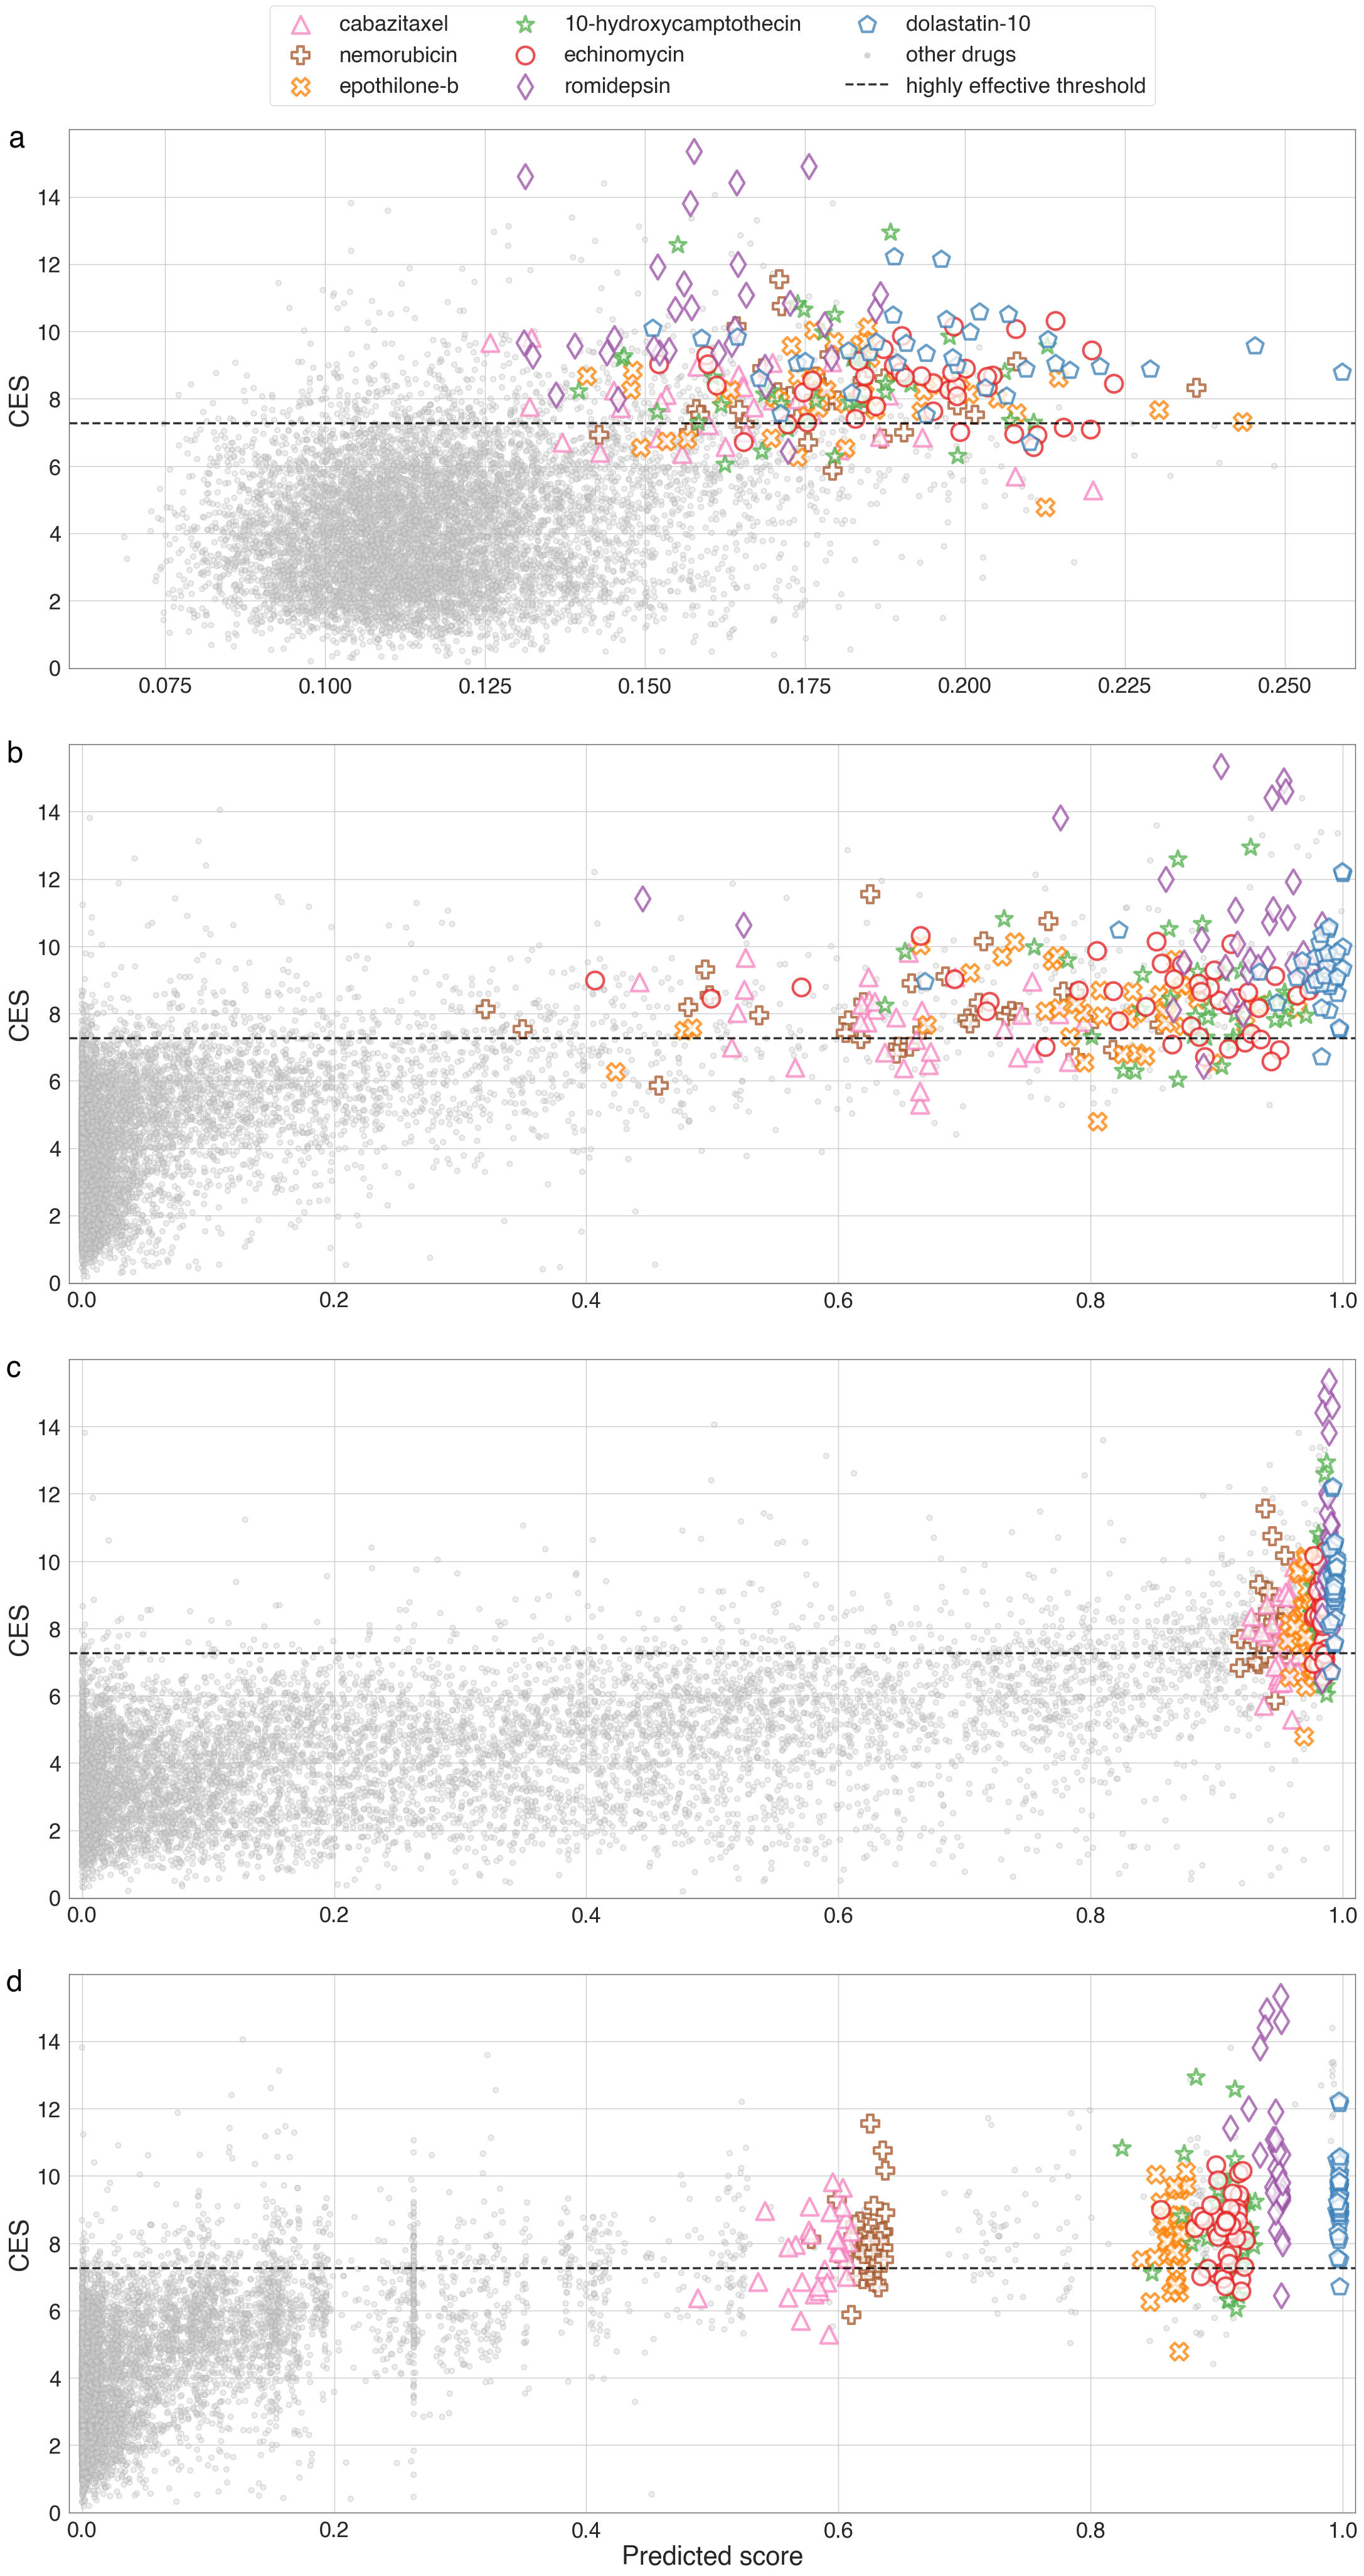

In [49]:
sns.set_theme()
sns.set_context("paper")
sns.set(font_scale = 2.25)
rc = {'axes.facecolor': 'white',
      'axes.grid': True,
      'grid.color': '0.8',
      'font.family': 'sans-serif',
      'font.sans-serif': 'Helvetica'}
plt.rcParams.update(rc)

facet_kws={'sharex': False, 'sharey': True}
g = sns.relplot(data=combined[combined.drug=='other'], x="pred", y="effectiveCont", kind='scatter',
                row="model", row_order=['DeepDSC', 'SiamCDR-RF', 'SiamCDR-LR', 'SiamCDR-DNN'],
                hue='drug', palette=edgePal, style='drug', markers=markers, 
                size='drug', sizes=sizes, alpha=0.4, edgecolor='darkgray',
                hue_order=[order[0]], style_order=[order[0]], size_order=[order[0]],
                height=10, aspect=2.25, facet_kws=facet_kws)

for model, ax in g.axes_dict.items():
    xloc = -0.06
    if model == 'DeepDSC':
        txt = 'a'
        xloc = 0.0615-0.011
        ax.set(xlim=[0.06, 0.261], ylim=[-0.01, 16])
    else:
        ax.set(xlim=[-0.01, 1.01])
        if model == 'SiamCDR-RF':
            txt = 'b'
        elif model == 'SiamCDR-LR':
            txt = 'c'
        else:
            txt = 'd'
            
    # Add letter indicating which subfigure it is 
    g.axes_dict[model].text(xloc, 15.5, txt, fontsize=34, 
                            color='black', weight='bold')
    
    df = combined.copy()
    df = df[df.model == model]
    
    # add line indicating threshold for binary ground truth
    ax.axhline(y=7.2734, color='black', linestyle='dashed', linewidth=2.5, 
               alpha=0.8, label='highly effective threshold')
    
    # plot top recommended drugs
    for drug in order[1:]:
        ax.scatter(data=df[df.drug == drug], x="pred", y="effectiveCont", marker=markers[drug],
                   edgecolor=edgePal[drug], facecolor='white', s=400, linewidth=3, alpha=0.75, label=drug) 
    
    # customize border
    ax.get_yticklabels()[-1].set_visible(False)
    for border in ['top', 'bottom', 'left', 'right']:
        ax.spines[border].set_visible(True)
        ax.spines[border].set_color("0.4")
        ax.spines[border].set_linewidth(1)

# customize legend
handles, _ = plt.gca().get_legend_handles_labels()
completeLabels = ['cabazitaxel', 'nemorubicin', 'epothilone-b', '10-hydroxycamptothecin', 
                  'echinomycin', 'romidepsin', 'dolastatin-10', 'other drugs', 'highly effective threshold']
completeHandles = [handles[2]] + [handles[1]] + handles[3:] + [g.legend.legendHandles[0]] + [handles[0]]
g.legend.remove()
g.axes_dict['DeepDSC'].legend(labels=completeLabels, handles=completeHandles, loc='upper center',
                        ncol=3, fontsize=25, bbox_to_anchor=(0.5, 1.25))

g.set_titles(row_template="")
g.set_xlabels(label='Predicted score', fontsize=30)
g.set_ylabels(label='CES', fontsize=30)
# plt.savefig("./figure2.pdf", dpi=1200, bbox_inches="tight")
plt.show()